In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import activation, Dropout, Dense
from keras.layers import Flatten, LSTM, CuDNNLSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re

In [2]:
#Import the Pre-processed dataset modified to 365 days
x_train = pd.read_csv('Power365.csv')
y_train = pd.read_csv('AlwaysOn365.csv')
x_test = pd.read_csv('x_test30.csv')
y_test = pd.read_csv('y_test30.csv')

In [3]:
x_train

,power
0,73270
1,73330
2,73210
3,73130
4,72980
...,...
15767995,288870
15767996,270830
15767997,235440
15767998,227970


In [4]:
y_train

,applianceType,startTime,stopTime,usage,unit
0,AlwaysOn,1509494400,1509580800,4.1516,kWh
1,AlwaysOn,1509580800,1509667200,4.0285,kWh
2,AlwaysOn,1509667200,1509753600,4.8795,kWh
3,AlwaysOn,1509753600,1509840000,4.2236,kWh
4,AlwaysOn,1509840000,1509926400,3.9257,kWh
...,...,...,...,...,...
360,AlwaysOn,1540425600,1540512000,4.7498,kWh
361,AlwaysOn,1540512000,1540598400,9.2016,kWh
362,AlwaysOn,1540598400,1540684800,5.7921,kWh
363,AlwaysOn,1540684800,1540771200,4.5130,kWh


In [5]:
#scaler = MinMaxScaler()
x = np.array(x_train.power)
#x = x.reshape(-1, 1)
X_train = x.reshape(365,43200,1) #converts the list X into 3-dimensional shape with 500 samples, 43200 time-steps, and 1 feature
X_train = X_train.astype("float32")
X_test = np.array(x_test.power)
X_test = X_test.reshape(30,43200)
X_test = X_test.astype("float32")

Y_train = np.array(y_train.usage)
Y_train = Y_train.astype("float32")
Y_test = np.array(y_test.usage)
Y_test = Y_test.astype("float32")
#Y = Y.array.reshape(-1, 1)


In [6]:
print(Y_train.ndim)
print(Y_test.ndim)
print(X_train.ndim)
print(X_test.ndim)

1
1
3
2


In [7]:
print("Num GPU Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Num GPU Available:  1
True


In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [52]:
#Create the model LSTM Bidirectional
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(20), input_shape=(43200, 1)))
model.add(Dropout(0.3))
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(800, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(400, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(100, activation="relu"))
model.add(Dense(1))

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 40)               3680      
 nal)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 40)                0         
                                                                 
 dense_34 (Dense)            (None, 1000)              41000     
                                                                 
 dropout_28 (Dropout)        (None, 1000)              0         
                                                                 
 dense_35 (Dense)            (None, 800)               800800    
                                                                 
 dropout_29 (Dropout)        (None, 800)               0         
                                                     

In [53]:
model.compile(optimizer='adam', loss='mse')

In [54]:
history = model.fit(X_train, Y_train, epochs=100, validation_split=0.4, verbose=1, batch_size=1)

Epoch 1/100
219/219 [==============================] - 160s 678ms/step - loss: 2.4484 - val_loss: 4.0825
Epoch 2/100
219/219 [==============================] - 146s 666ms/step - loss: 1.7339 - val_loss: 6.1221
Epoch 3/100
219/219 [==============================] - 146s 668ms/step - loss: 1.6466 - val_loss: 4.0518
Epoch 4/100
219/219 [==============================] - 146s 668ms/step - loss: 1.5306 - val_loss: 3.3132
Epoch 5/100
219/219 [==============================] - 146s 666ms/step - loss: 1.5021 - val_loss: 3.6481
Epoch 6/100
219/219 [==============================] - 146s 668ms/step - loss: 1.5215 - val_loss: 4.1592
Epoch 7/100
219/219 [==============================] - 146s 668ms/step - loss: 1.9176 - val_loss: 3.2602
Epoch 8/100
219/219 [==============================] - 147s 672ms/step - loss: 1.6010 - val_loss: 3.6817
Epoch 9/100
219/219 [==============================] - 147s 671ms/step - loss: 1.3995 - val_loss: 3.6728
Epoch 10/100
219/219 [==============================] -

219/219 [==============================] - 141s 645ms/step - loss: 0.9130 - val_loss: 3.2653
Epoch 79/100
219/219 [==============================] - 152s 694ms/step - loss: 0.9121 - val_loss: 3.2317
Epoch 80/100
219/219 [==============================] - 146s 667ms/step - loss: 0.9236 - val_loss: 3.2569
Epoch 81/100
219/219 [==============================] - 154s 706ms/step - loss: 0.9173 - val_loss: 3.3260
Epoch 82/100
219/219 [==============================] - 162s 740ms/step - loss: 0.8993 - val_loss: 3.4408
Epoch 83/100
219/219 [==============================] - 137s 628ms/step - loss: 0.9133 - val_loss: 3.5266
Epoch 84/100
219/219 [==============================] - 100s 458ms/step - loss: 0.9104 - val_loss: 3.2271
Epoch 85/100
219/219 [==============================] - 138s 632ms/step - loss: 0.9166 - val_loss: 3.2627
Epoch 86/100
219/219 [==============================] - 148s 678ms/step - loss: 0.9174 - val_loss: 3.2521
Epoch 87/100
219/219 [==============================] - 147

In [55]:
model.save('modeloF.h5')

In [ ]:
# Load the saved model
#from keras.models import load_model
#model = load_model('modelo1.h5')

In [56]:
evaluation_result = model.evaluate(X_test, Y_test, batch_size=1)


30/30 [==============================] - 6s 207ms/step - loss: 1.5582


In [57]:
#X_test = X_test.reshape(30,43200,1)
test_output = model.predict(X_test, verbose=1, batch_size=1)
print(test_output)
print(test_output.shape)

30/30 [==============================] - 6s 210ms/step
[[4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]
 [4.632007]]
(30, 1)


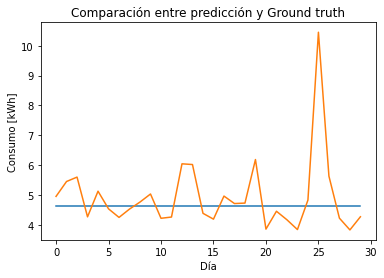

In [58]:
x_axis = np.arange(0, len(test_output))
plt.plot(x_axis, test_output) 
plt.plot(x_axis, Y_test)

plt.title("Comparación entre predicción y Ground truth")
plt.xlabel("Día")
plt.ylabel("Consumo [kWh]") 

plt.show()

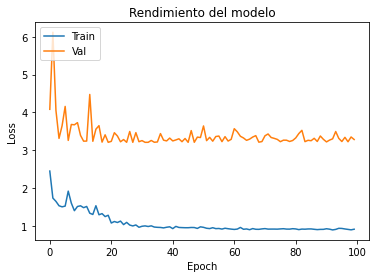

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Rendimiento del modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()